In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, LSTM, concatenate
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras import optimizers
from keras.utils import to_categorical
import seaborn as sns

In [2]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/UCI_HAR_Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/UCI_HAR_Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/UCI_HAR_Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/UCI_HAR_Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/UCI_HAR_Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352, 1), (2947, 1))

In [5]:
# Create train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=  y_train)

In [6]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [7]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

y_val_array = np.array(y_val)
val_set = np.c_[X_val, y_val_array]

X_train, y_train = split_sequences(train_set, 9)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 9)
print(X_test.shape, y_test.shape)

X_val, y_val = split_sequences(val_set, 9)
print(X_val.shape, y_val.shape)

(5506, 9, 561) (5506,)
(2939, 9, 561) (2939,)
(1830, 9, 561) (1830,)


In [8]:
# Convert output variables to categorical for CNN
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

y_val = to_categorical(y_val)
print(y_val.shape)

(5506, 7)
(2939, 7)
(1830, 7)


In [9]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

9 561 7


In [10]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 64)             107776    
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 128)               57472     
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 166,151
Trainable params: 166,151
Non-trainable params: 0
_________________________________________________________________


In [11]:
# validation_split = 0.1
train_epochs = 10
history = model.fit(X_train, y_train, epochs=train_epochs, verbose=True,  validation_data = (X_val, y_val))


Epoch 1/10
173/173 [==============================] - 2s 6ms/step - loss: 1.2176 - accuracy: 0.4364 - val_loss: 0.7816 - val_accuracy: 0.5765
Epoch 2/10
173/173 [==============================] - 1s 4ms/step - loss: 0.5511 - accuracy: 0.7614 - val_loss: 0.4024 - val_accuracy: 0.8388
Epoch 3/10
173/173 [==============================] - 1s 5ms/step - loss: 0.3272 - accuracy: 0.8667 - val_loss: 0.2742 - val_accuracy: 0.8940
Epoch 4/10
173/173 [==============================] - 1s 4ms/step - loss: 0.2376 - accuracy: 0.9066 - val_loss: 0.2640 - val_accuracy: 0.8858
Epoch 5/10
173/173 [==============================] - 1s 4ms/step - loss: 0.1734 - accuracy: 0.9346 - val_loss: 0.1928 - val_accuracy: 0.9175
Epoch 6/10
173/173 [==============================] - 1s 5ms/step - loss: 0.1411 - accuracy: 0.9464 - val_loss: 0.1841 - val_accuracy: 0.9268
Epoch 7/10
173/173 [==============================] - 1s 4ms/step - loss: 0.1203 - accuracy: 0.9548 - val_loss: 0.2281 - val_accuracy: 0.9016
Epoch 

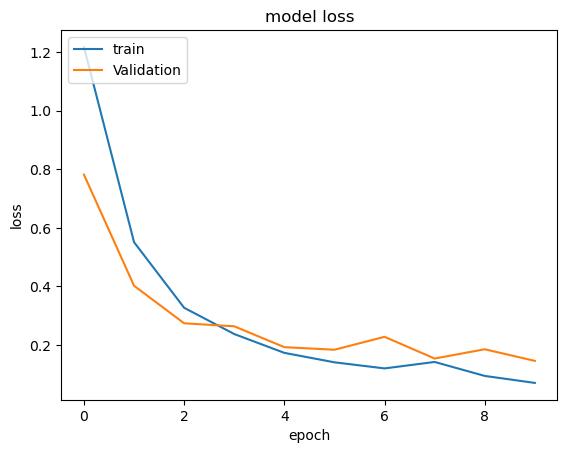

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [13]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = y_pred.reshape(-1,1)
y_pred.shape

92/92 [==============================] - 0s 2ms/step


(2939, 1)

In [14]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [15]:
# Results summarizer function (scores, confusion matrix) for classification results
def results_summarizer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    activity_map = {
    }
    plt.figure(figsize=(10, 8))

    sns.heatmap(cm,
                annot=True,
                cmap='Blues',
                xticklabels=activity_map.values(),
                yticklabels=activity_map.values()
               )

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Activity')
    plt.ylabel('Actual Activity')
    plt.show()

    print(f'Accuracy Score: ' + '{:.4%}'.format(acc))
    print(f'Precision Score: ' + '{:.4%}'.format(prec))
    print(f'Recall Score: ' + '{:.4%}'.format(rec))
    print(f'F_1 Score: ' + '{:.4%}'.format(f1))

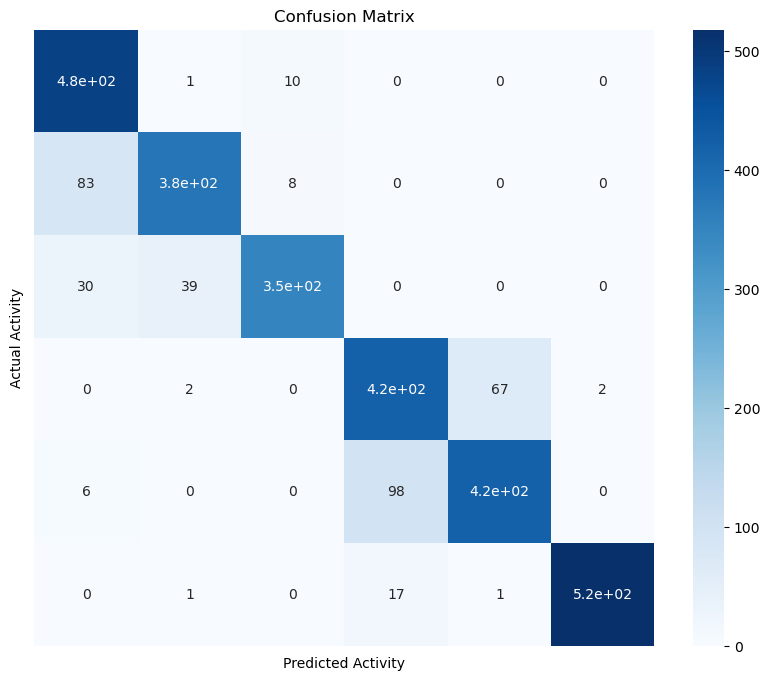

Accuracy Score: 87.5808%
Precision Score: 88.2400%
Recall Score: 87.3646%
F_1 Score: 87.5092%


In [16]:
y_true = np.argmax(y_test, axis=1).reshape(-1,1)
# Show results
# Note: Needed slice test data to 25 and onwards to match predictions due to time step in model
results_summarizer(y_true, y_pred)

In [17]:
#model 2
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(n_outputs, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 7, 64)             107776    
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 64)             12352     
                                                                 
 flatten_1 (Flatten)         (None, 320)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               41088     
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 162,119
Trainable params: 162,119
Non-trainable params: 0
_________________________________________________________________


In [18]:
# validation_split = 0.1
train_epochs = 10
history = model.fit(X_train, y_train, epochs=train_epochs, verbose=True,  validation_data = (X_val, y_val))

Epoch 1/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0717 - accuracy: 0.9733 - val_loss: 0.1866 - val_accuracy: 0.9328
Epoch 2/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0575 - accuracy: 0.9798 - val_loss: 0.1548 - val_accuracy: 0.9410
Epoch 3/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0534 - accuracy: 0.9798 - val_loss: 0.1596 - val_accuracy: 0.9459
Epoch 4/10
173/173 [==============================] - 1s 4ms/step - loss: 0.0508 - accuracy: 0.9815 - val_loss: 0.5867 - val_accuracy: 0.8404
Epoch 5/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0576 - accuracy: 0.9777 - val_loss: 0.1298 - val_accuracy: 0.9497
Epoch 6/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0392 - accuracy: 0.9871 - val_loss: 0.1890 - val_accuracy: 0.9377
Epoch 7/10
173/173 [==============================] - 1s 5ms/step - loss: 0.0528 - accuracy: 0.9806 - val_loss: 0.2051 - val_accuracy: 0.9333
Epoch 